# Experimentación - LSTM 



## 1. Obtención de datos



In [2]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN
from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils import train_lstm
from utils import trainer
import utils.train_lstm
dtype = torch.float
device = torch.device("cpu")

## Prueba - predicción por tipos

### Gen trip

In [6]:
problem = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [7]:
n_div_gt = loader.div

#### Sencilla 

In [8]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

dataloader_gt = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])

model_gt, losses_gt, eval_losses_gt, r2scores_eval_gt = train_lstm.train_lstm_model(dataset_gt, params_model, dataloader_gt, num_epochs=30, lr=0.001, problem=problem, save_model = False, path_save = "./results" )



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN ===================

Epoch 1/30 | Train Loss: 0.0510 | Eval Loss: 0.0845 | Eval R2: -8.2851 | 
Epoch 2/30 | Train Loss: 0.0138 | Eval Loss: 0.0845 | Eval R2: -8.1360 | 
Epoch 3/30 | Train Loss: 0.0121 | Eval Loss: 0.0855 | Eval R2: -8.1906 | 
Epoch 4/30 | Train Loss: 0.0114 | Eval Loss: 0.0863 | Eval R2: -8.2660 | 
Epoch 5/30 | Train Loss: 0.0110 | Eval Loss: 0.0863 | Eval R2: -8.2862 | 
Epoch 6/30 | Train Loss: 0.0107 | Eval Loss: 0.0851 | Eval R2: -8.1323 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0840 | Eval R2: -8.0339 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0840 | Eval R2: -7.9828 | 
Epoch 9/30 | Train Loss: 0.0097 | Eval

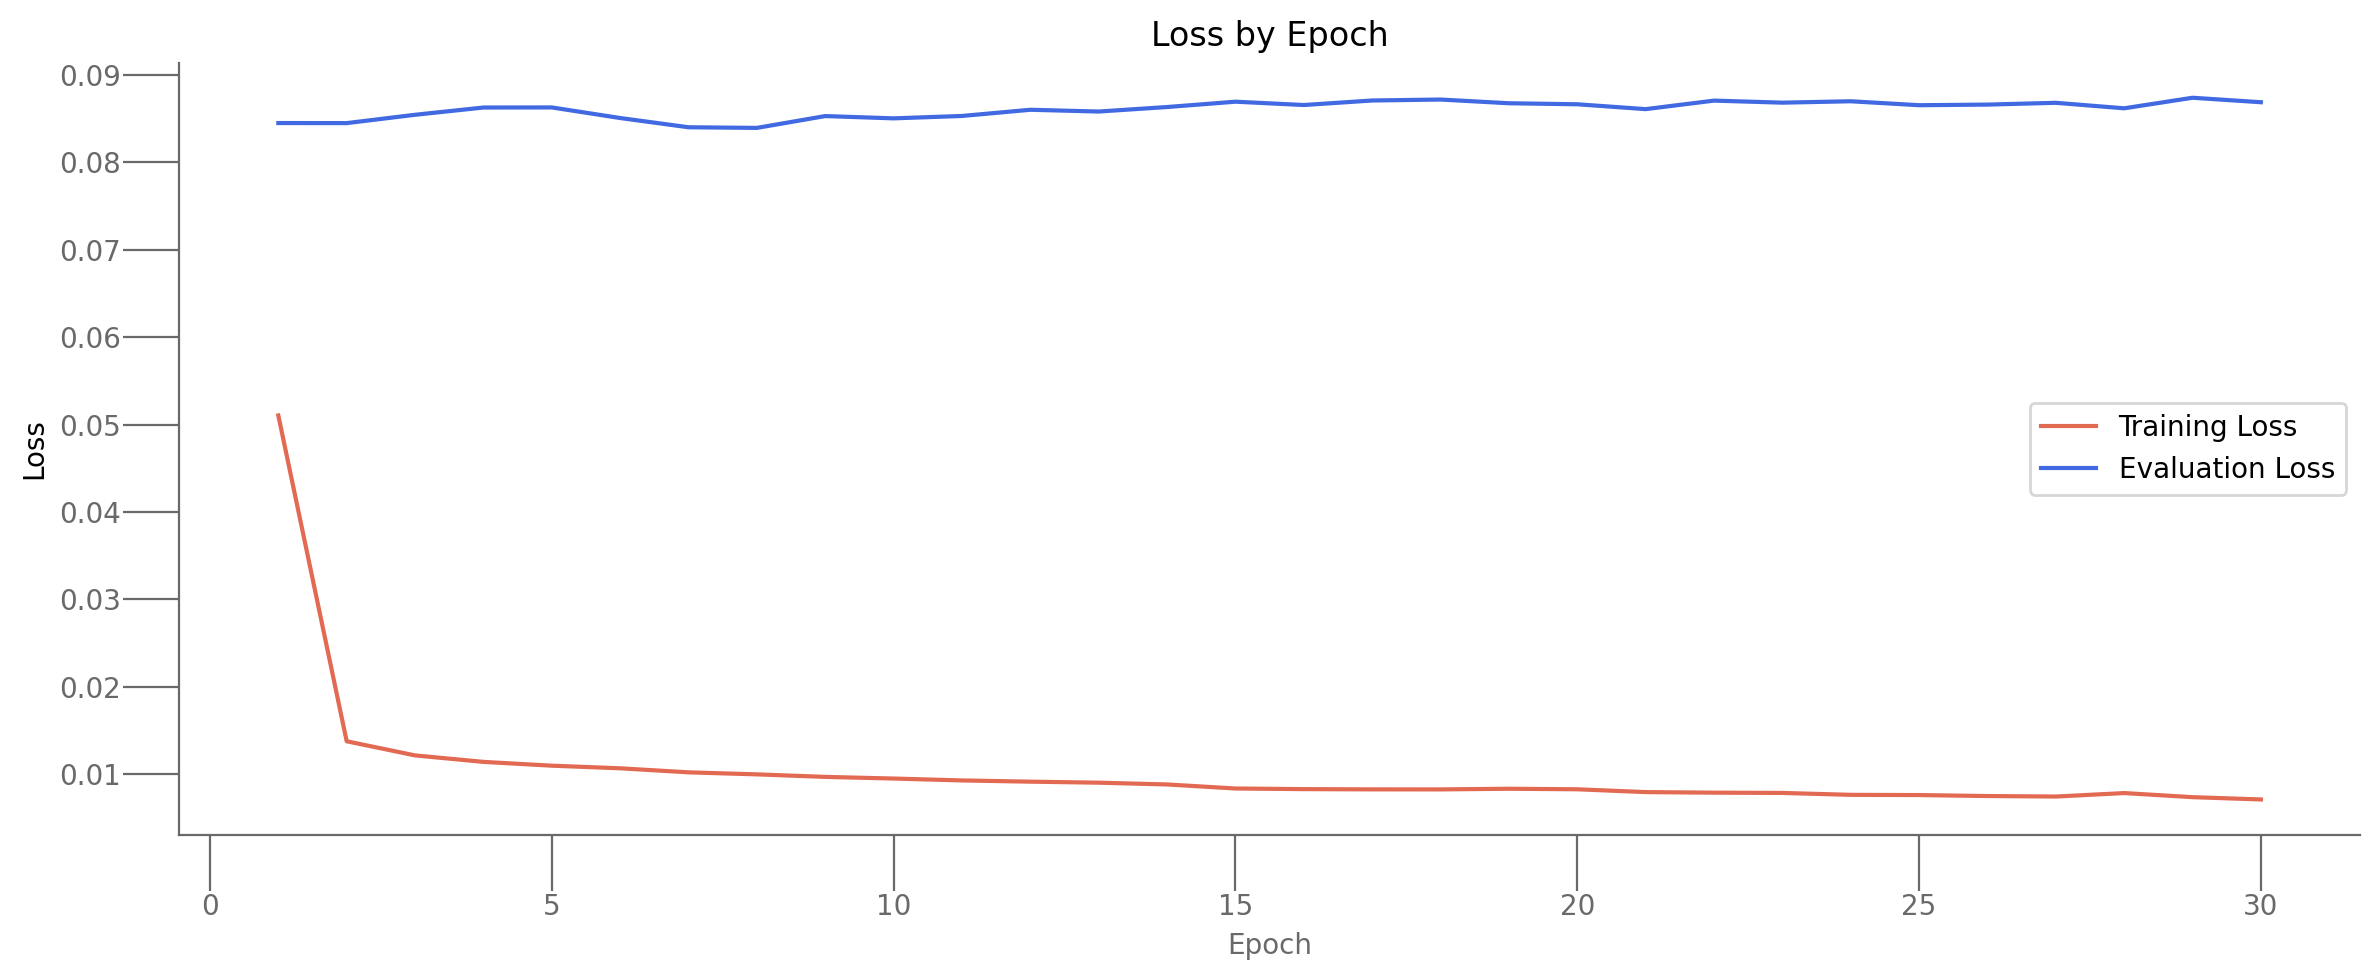

In [ ]:
plot_training_and_eval_losses(np.array(losses_gt), np.array(eval_losses_gt), 30, format_plot)

In [ ]:
r2score_tst, losses_tst, loss_nodes, predictions, real = train_lstm.test(model_gt, dataloader_gt)


==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


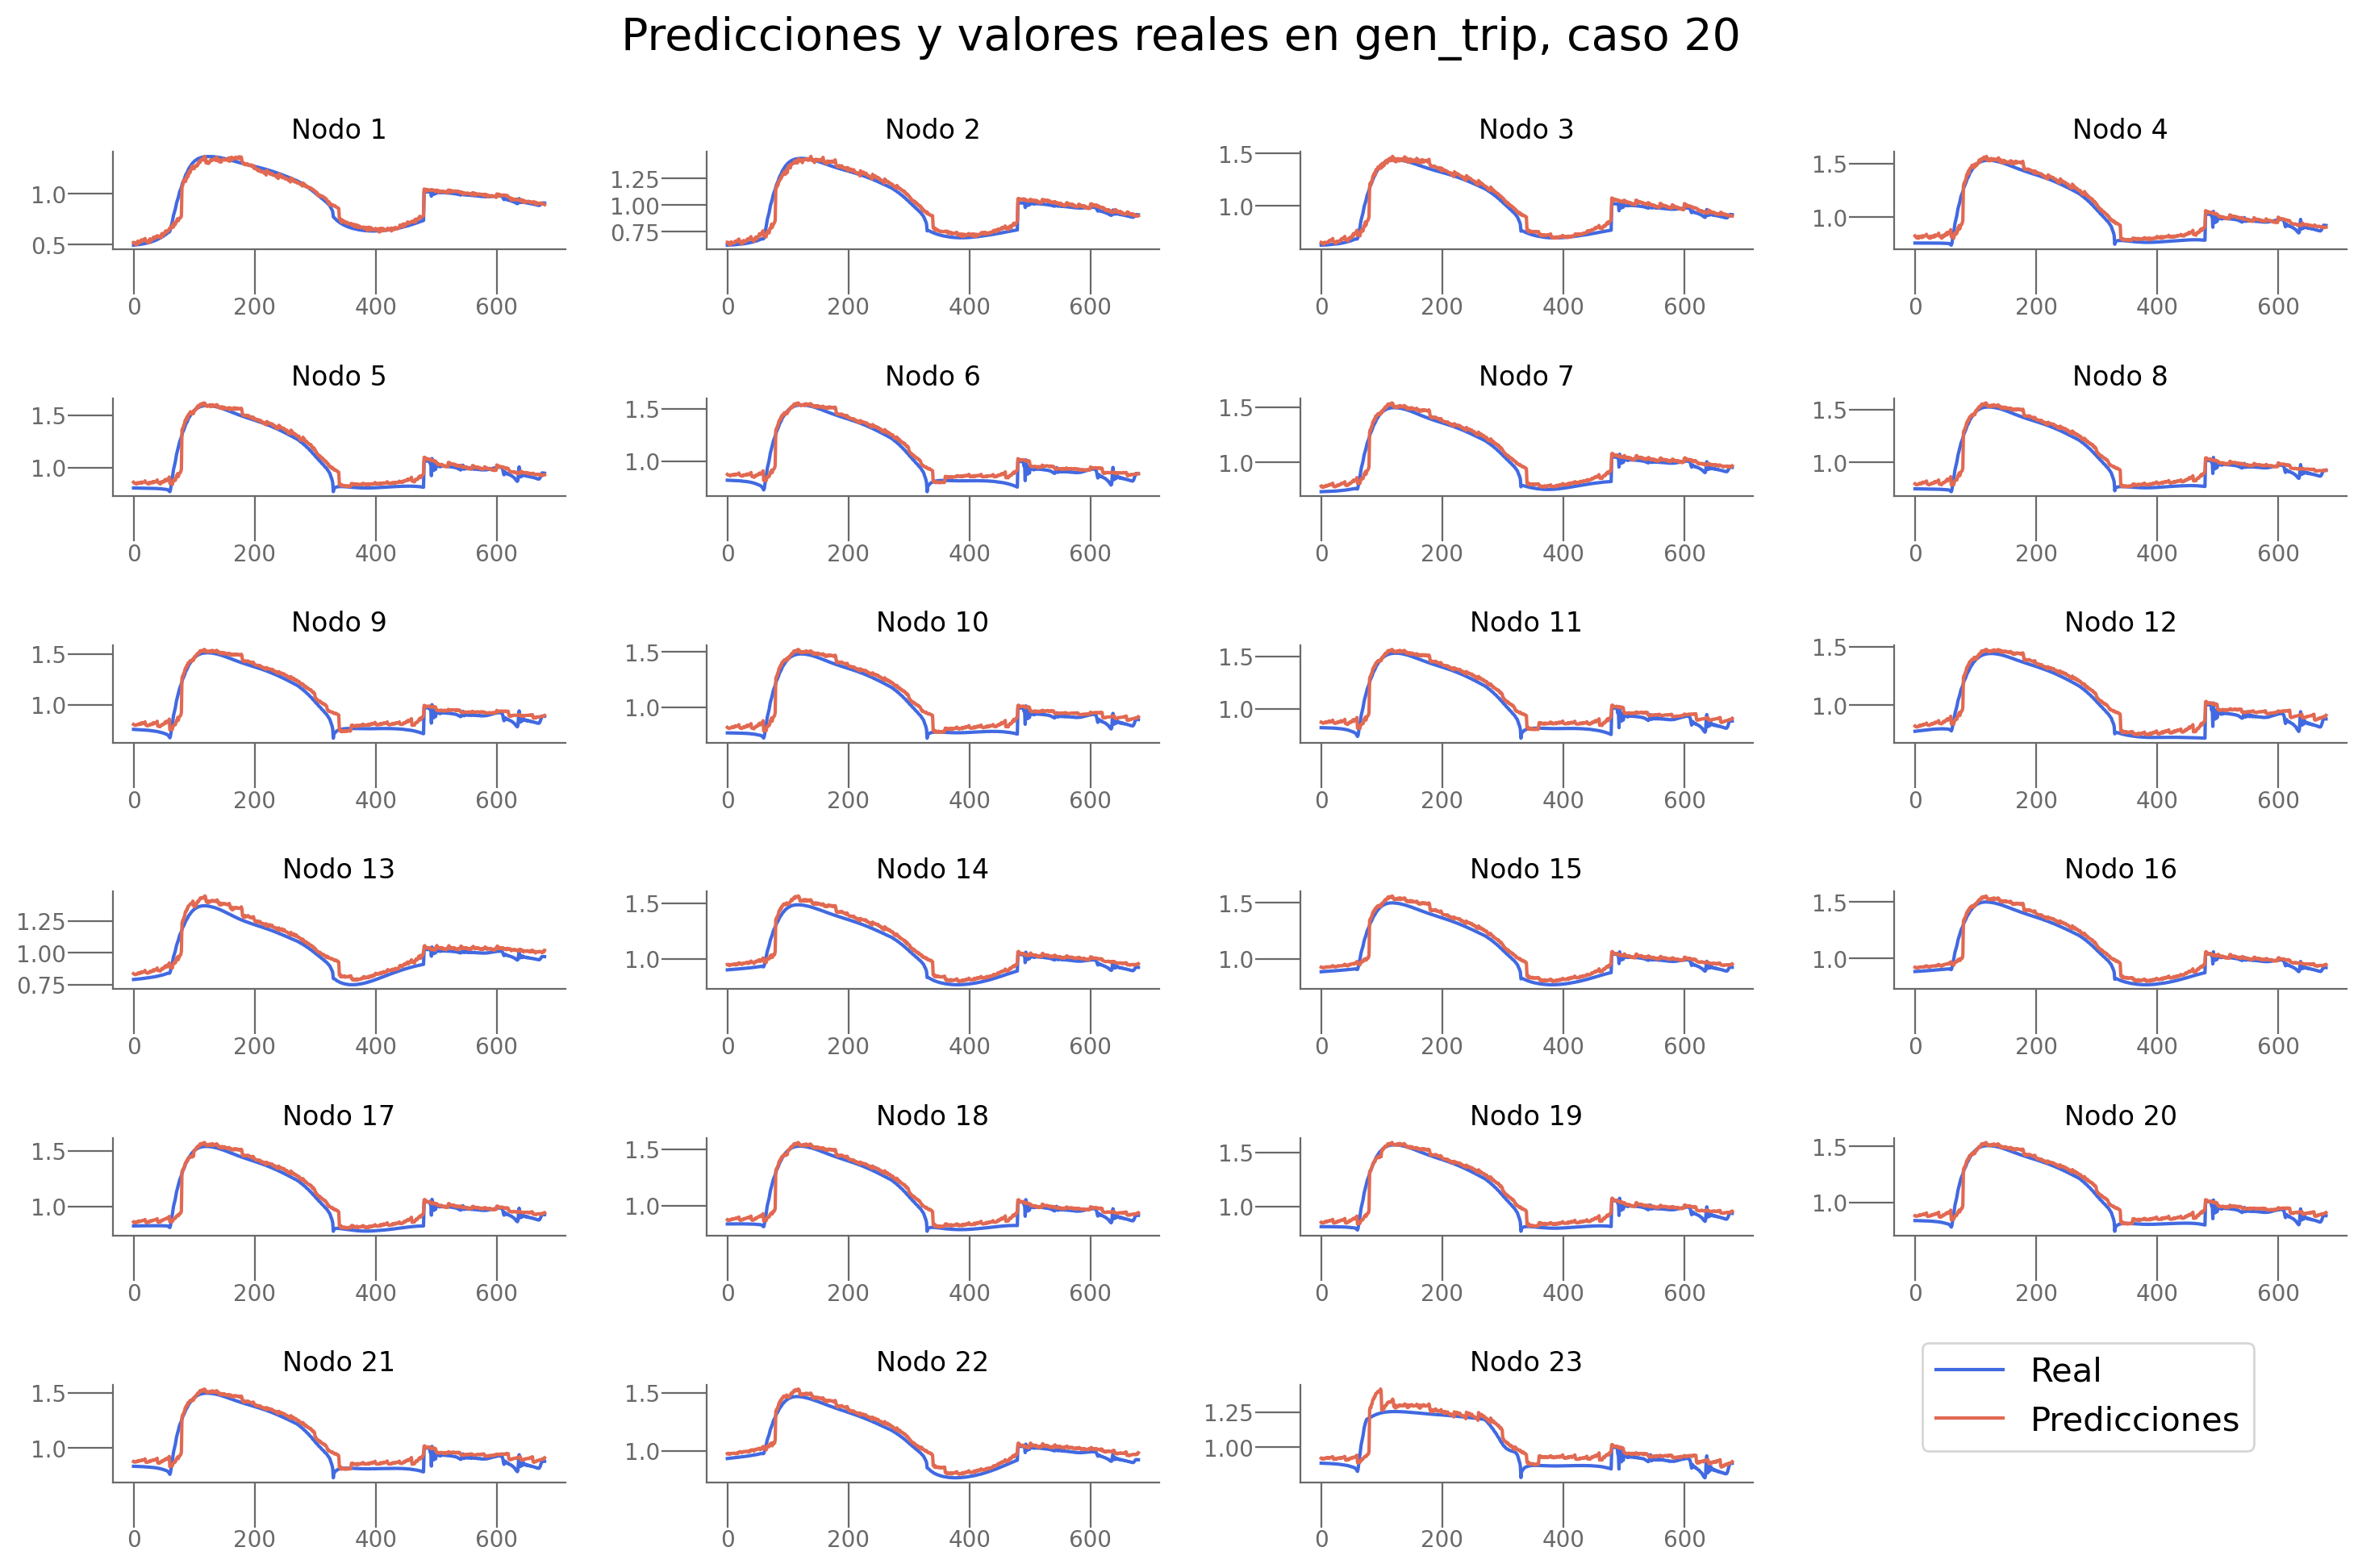

In [ ]:
plot_predictions(predictions, real, 20, 20, n_div_gt, problem)

In [ ]:
resultados = {
    "loss_test": np.mean(losses_tst),
    "r2_test": np.mean(r2score_tst),
    "loss_nodes" : np.mean(loss_nodes, axis=0),
    "r2_eval_final": r2scores_eval_gt[-1],
    "loss_eval_final": eval_losses_gt[-1],
    "loss_final": losses_gt[-1]
}


guardar_resultados(model_gt, "LSTM", problem, resultados_mejor_modelo=resultados, results_path = "./results",path_save_experiment=None, params=None)



==================== GUARDANDO RESULTADOS ===================

  Modelo Params Fichero_resultados_experimento  Loss_tst   R2_tst  \
0   LSTM   None                           None  0.007442  0.35825   

                                          Loss_nodes  R2_eval  Loss_eval  \
0  [0.0029240102, 0.0031518377, 0.00446385, 0.007... -8.13717   0.086898   

   Loss_final  
0    0.007102  

==================== RESULTADOS GUARDADOS ===================



### Bus trip

In [ ]:
problem = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [ ]:
n_div_bt = loader.div

#### Sencilla 

In [ ]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

dataloader_bt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])

model_bt, losses_bt, eval_losses_bt, r2scores_eval_bt = train_lstm.train_lstm_model(dataset_bt, params_model, dataloader_bt, num_epochs=30, lr=0.001, problem=problem, save_model = False, path_save = "./results" )



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN ===================

Epoch 1/30 | Train Loss: 0.0510 | Eval Loss: 0.0845 | Eval R2: -8.2851 | 
Epoch 2/30 | Train Loss: 0.0138 | Eval Loss: 0.0845 | Eval R2: -8.1360 | 
Epoch 3/30 | Train Loss: 0.0121 | Eval Loss: 0.0855 | Eval R2: -8.1906 | 
Epoch 4/30 | Train Loss: 0.0114 | Eval Loss: 0.0863 | Eval R2: -8.2660 | 
Epoch 5/30 | Train Loss: 0.0110 | Eval Loss: 0.0863 | Eval R2: -8.2862 | 
Epoch 6/30 | Train Loss: 0.0107 | Eval Loss: 0.0851 | Eval R2: -8.1323 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0840 | Eval R2: -8.0339 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0840 | Eval R2: -7.9828 | 
Epoch 9/30 | Train Loss: 0.0097 | Eval

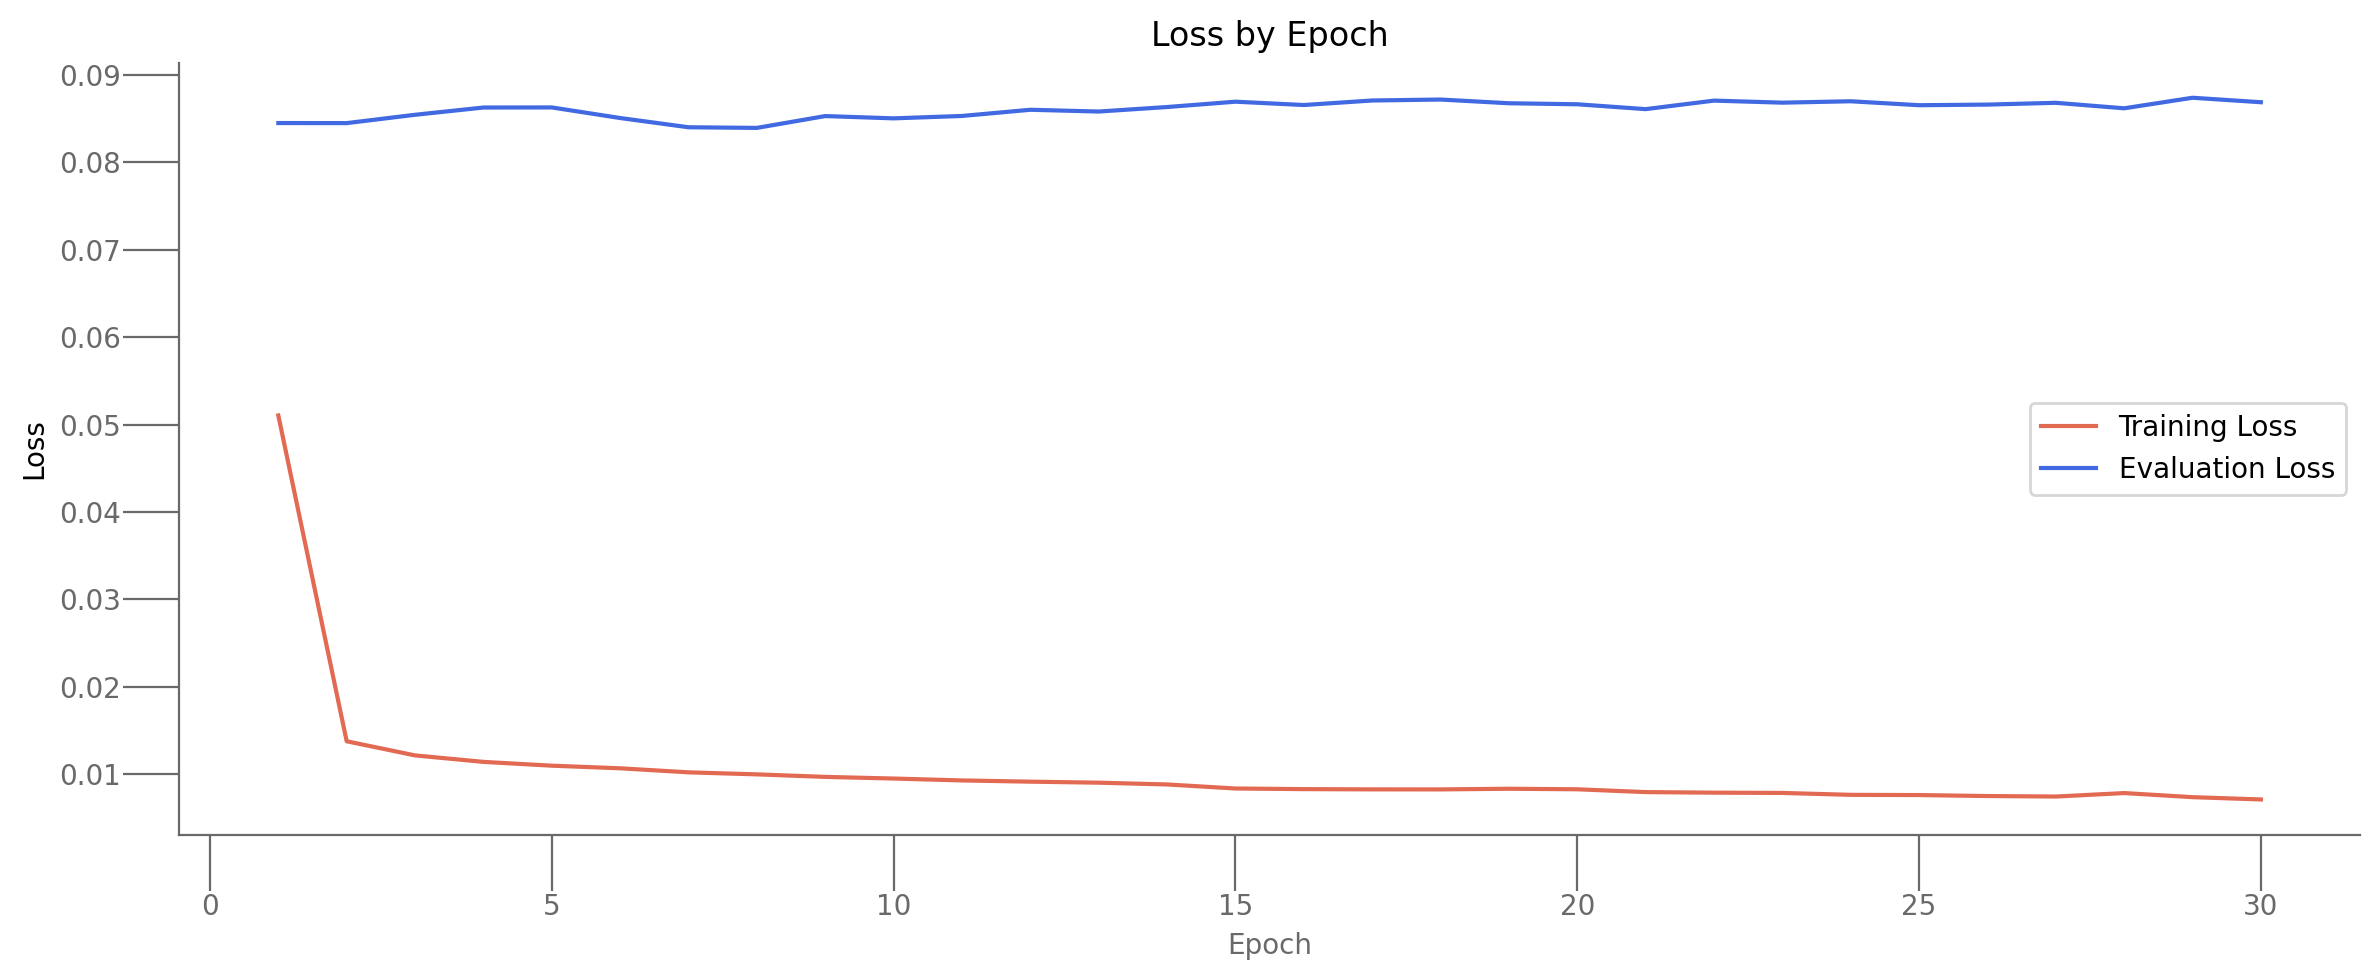

In [ ]:
plot_training_and_eval_losses(np.array(losses_bt), np.array(eval_losses_bt), 30, format_plot)

In [ ]:
r2score_tst_bt, losses_tst_bt, loss_nodes_bt, predictions_bt, real_bt = train_lstm.test(model_bt, dataloader_bt)


==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


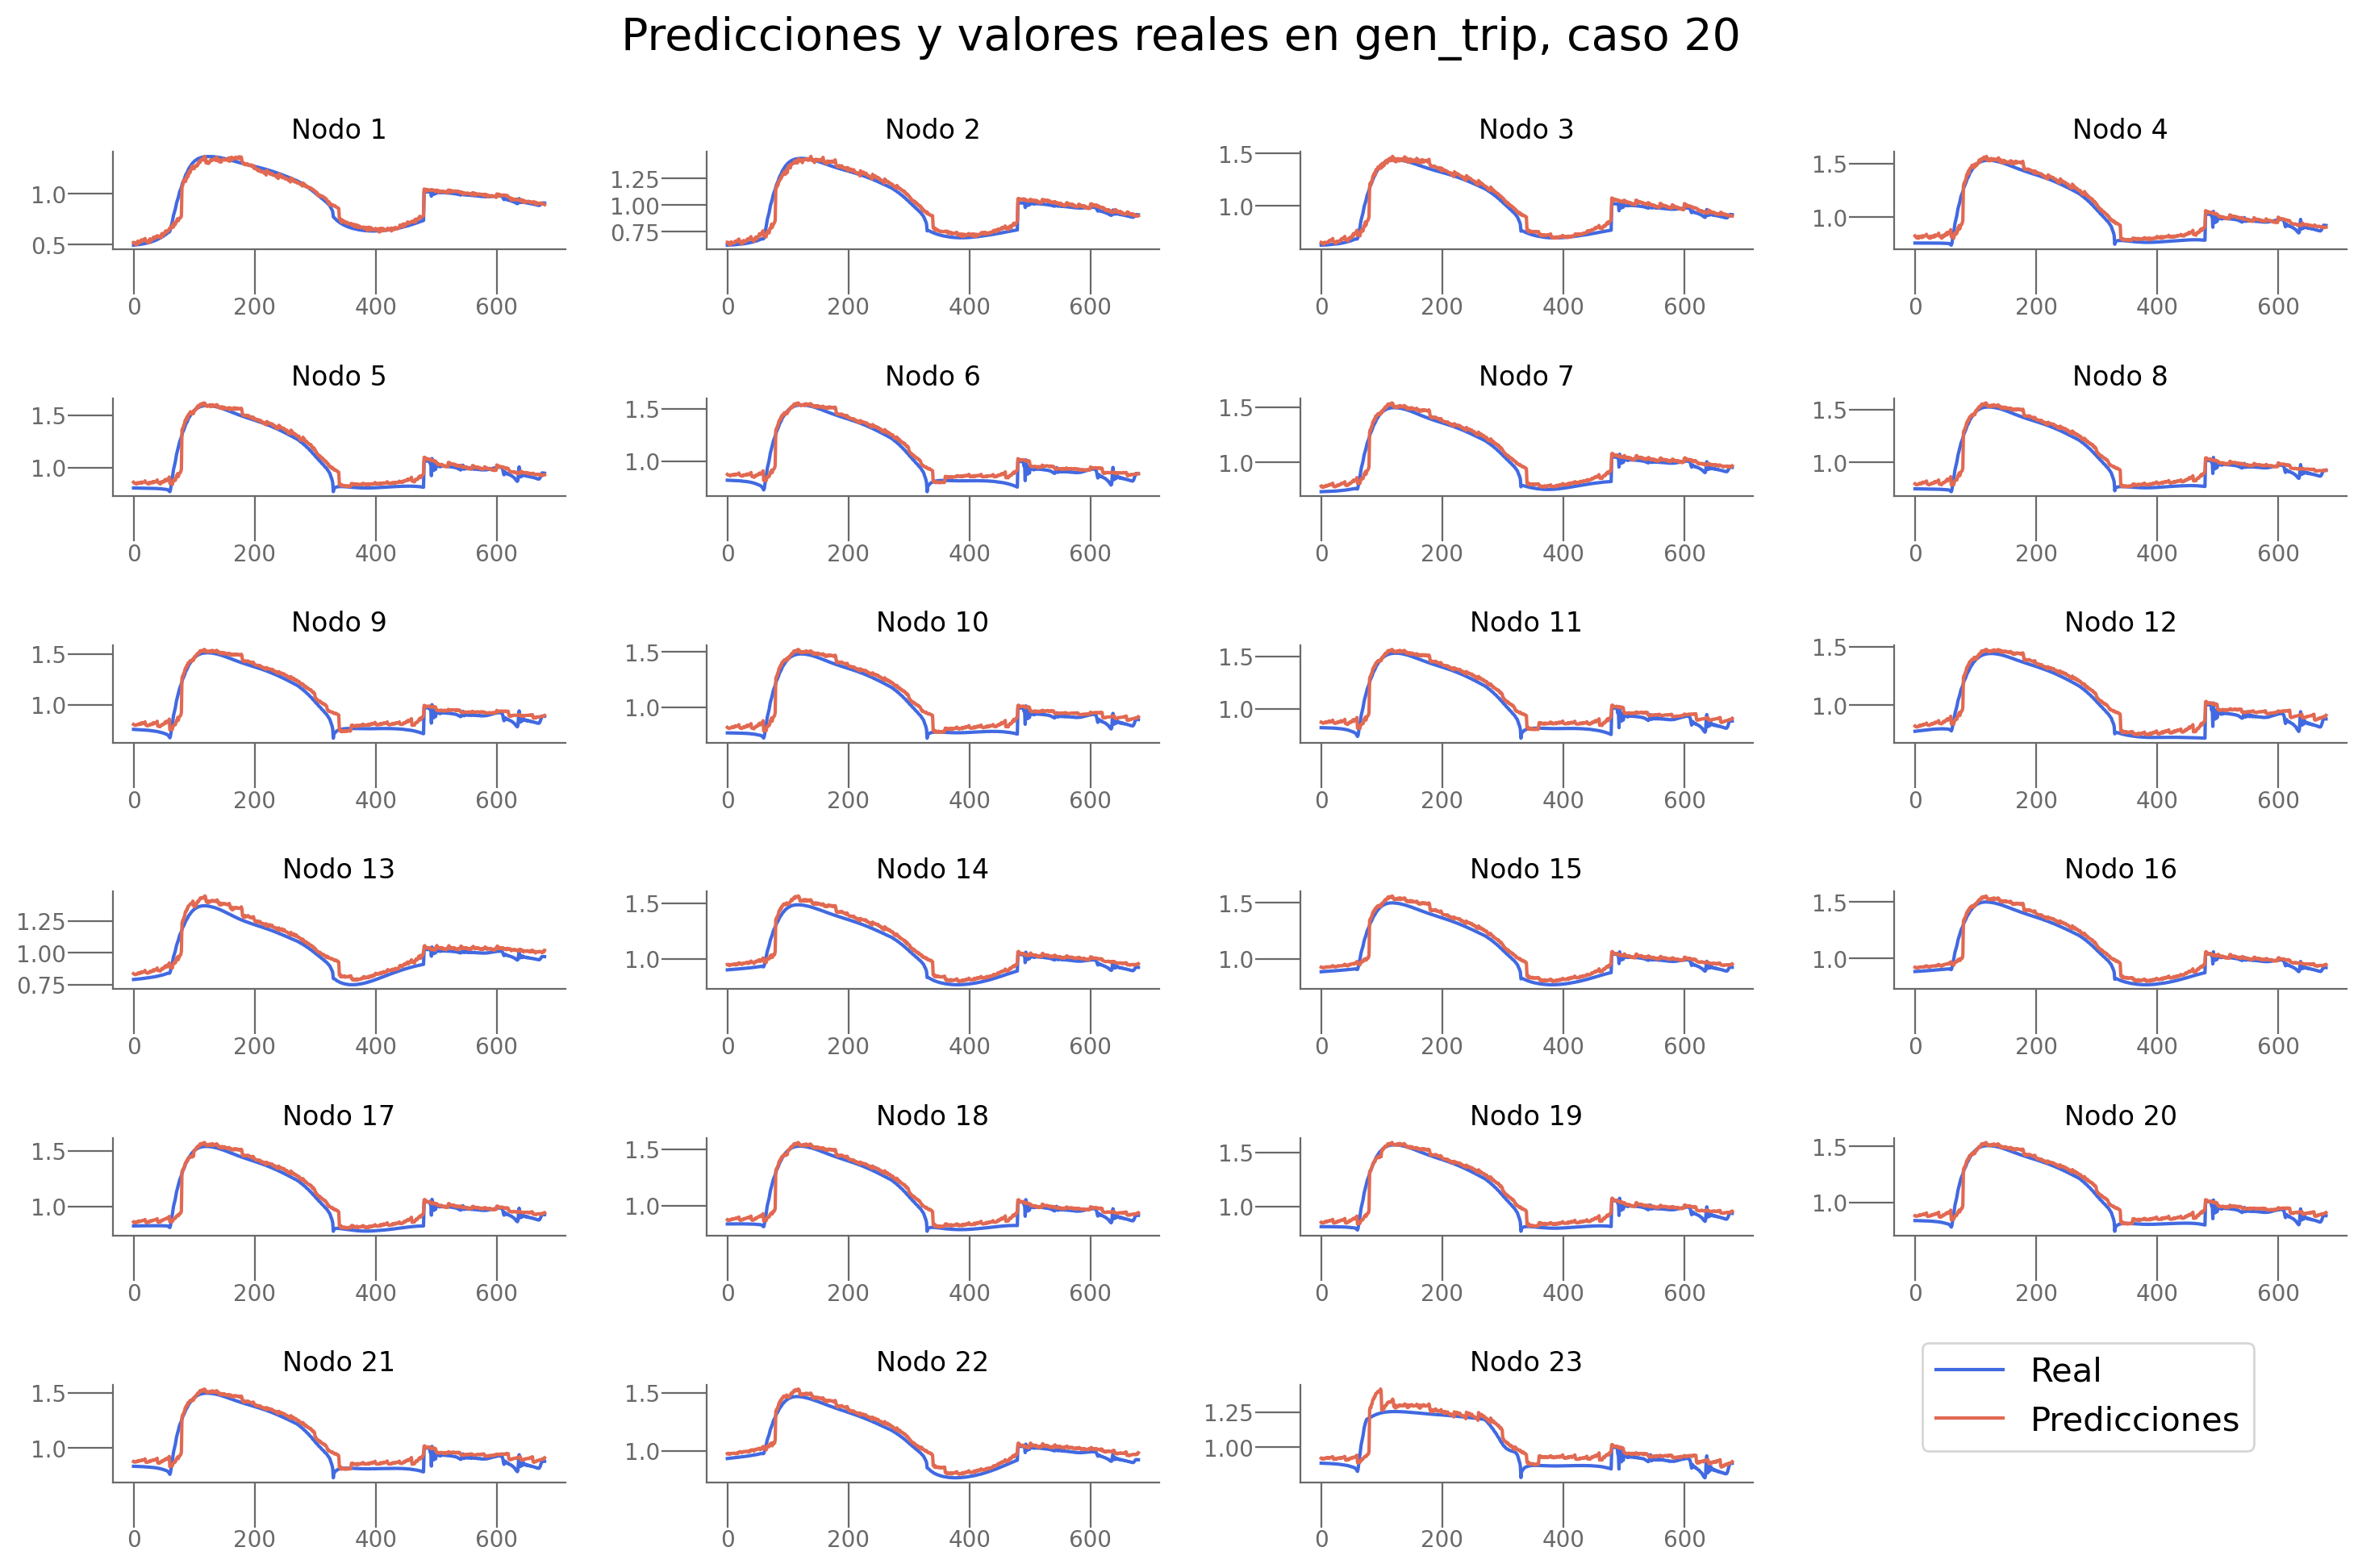

In [ ]:
plot_predictions(predictions_bt, real_bt, 20, 0, n_div_bt, problem)

In [ ]:
resultados_bt = {
    "loss_test": np.mean(losses_tst_bt),
    "r2_test": np.mean(r2score_tst_bt),
    "loss_nodes" : np.mean(loss_nodes_bt, axis=0),
    "r2_eval_final": r2scores_eval_bt[-1],
    "loss_eval_final": eval_losses_bt[-1],
    "loss_final": losses_bt[-1]
}


guardar_resultados(model_bt, "LSTM", problem, resultados_mejor_modelo=resultados_bt, results_path = "./results",path_save_experiment=None, params=None)



==================== GUARDANDO RESULTADOS ===================

  Modelo Params Fichero_resultados_experimento  Loss_tst   R2_tst  \
0   LSTM   None                           None  0.007442  0.35825   

                                          Loss_nodes  R2_eval  Loss_eval  \
0  [0.0029240102, 0.0031518377, 0.00446385, 0.007... -8.13717   0.086898   

   Loss_final  
0    0.007102  

==================== RESULTADOS GUARDADOS ===================



### Bus fault

In [ ]:
problem = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [ ]:
n_div_bf = loader.div

#### Sencilla 

In [ ]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

dataloader_bf = trainer.train_test_val_split(dataset_bf, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])

model_bf, losses_bf, eval_losses_bf, r2scores_eval_bf = train_lstm.train_lstm_model(dataset_bf, params_model, dataloader_bf, num_epochs=30, lr=0.001, problem=problem, save_model = False, path_save = "./results" )



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN ===================

Epoch 1/30 | Train Loss: 0.0510 | Eval Loss: 0.0845 | Eval R2: -8.2851 | 
Epoch 2/30 | Train Loss: 0.0138 | Eval Loss: 0.0845 | Eval R2: -8.1360 | 
Epoch 3/30 | Train Loss: 0.0121 | Eval Loss: 0.0855 | Eval R2: -8.1906 | 
Epoch 4/30 | Train Loss: 0.0114 | Eval Loss: 0.0863 | Eval R2: -8.2660 | 
Epoch 5/30 | Train Loss: 0.0110 | Eval Loss: 0.0863 | Eval R2: -8.2862 | 
Epoch 6/30 | Train Loss: 0.0107 | Eval Loss: 0.0851 | Eval R2: -8.1323 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0840 | Eval R2: -8.0339 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0840 | Eval R2: -7.9828 | 
Epoch 9/30 | Train Loss: 0.0097 | Eval

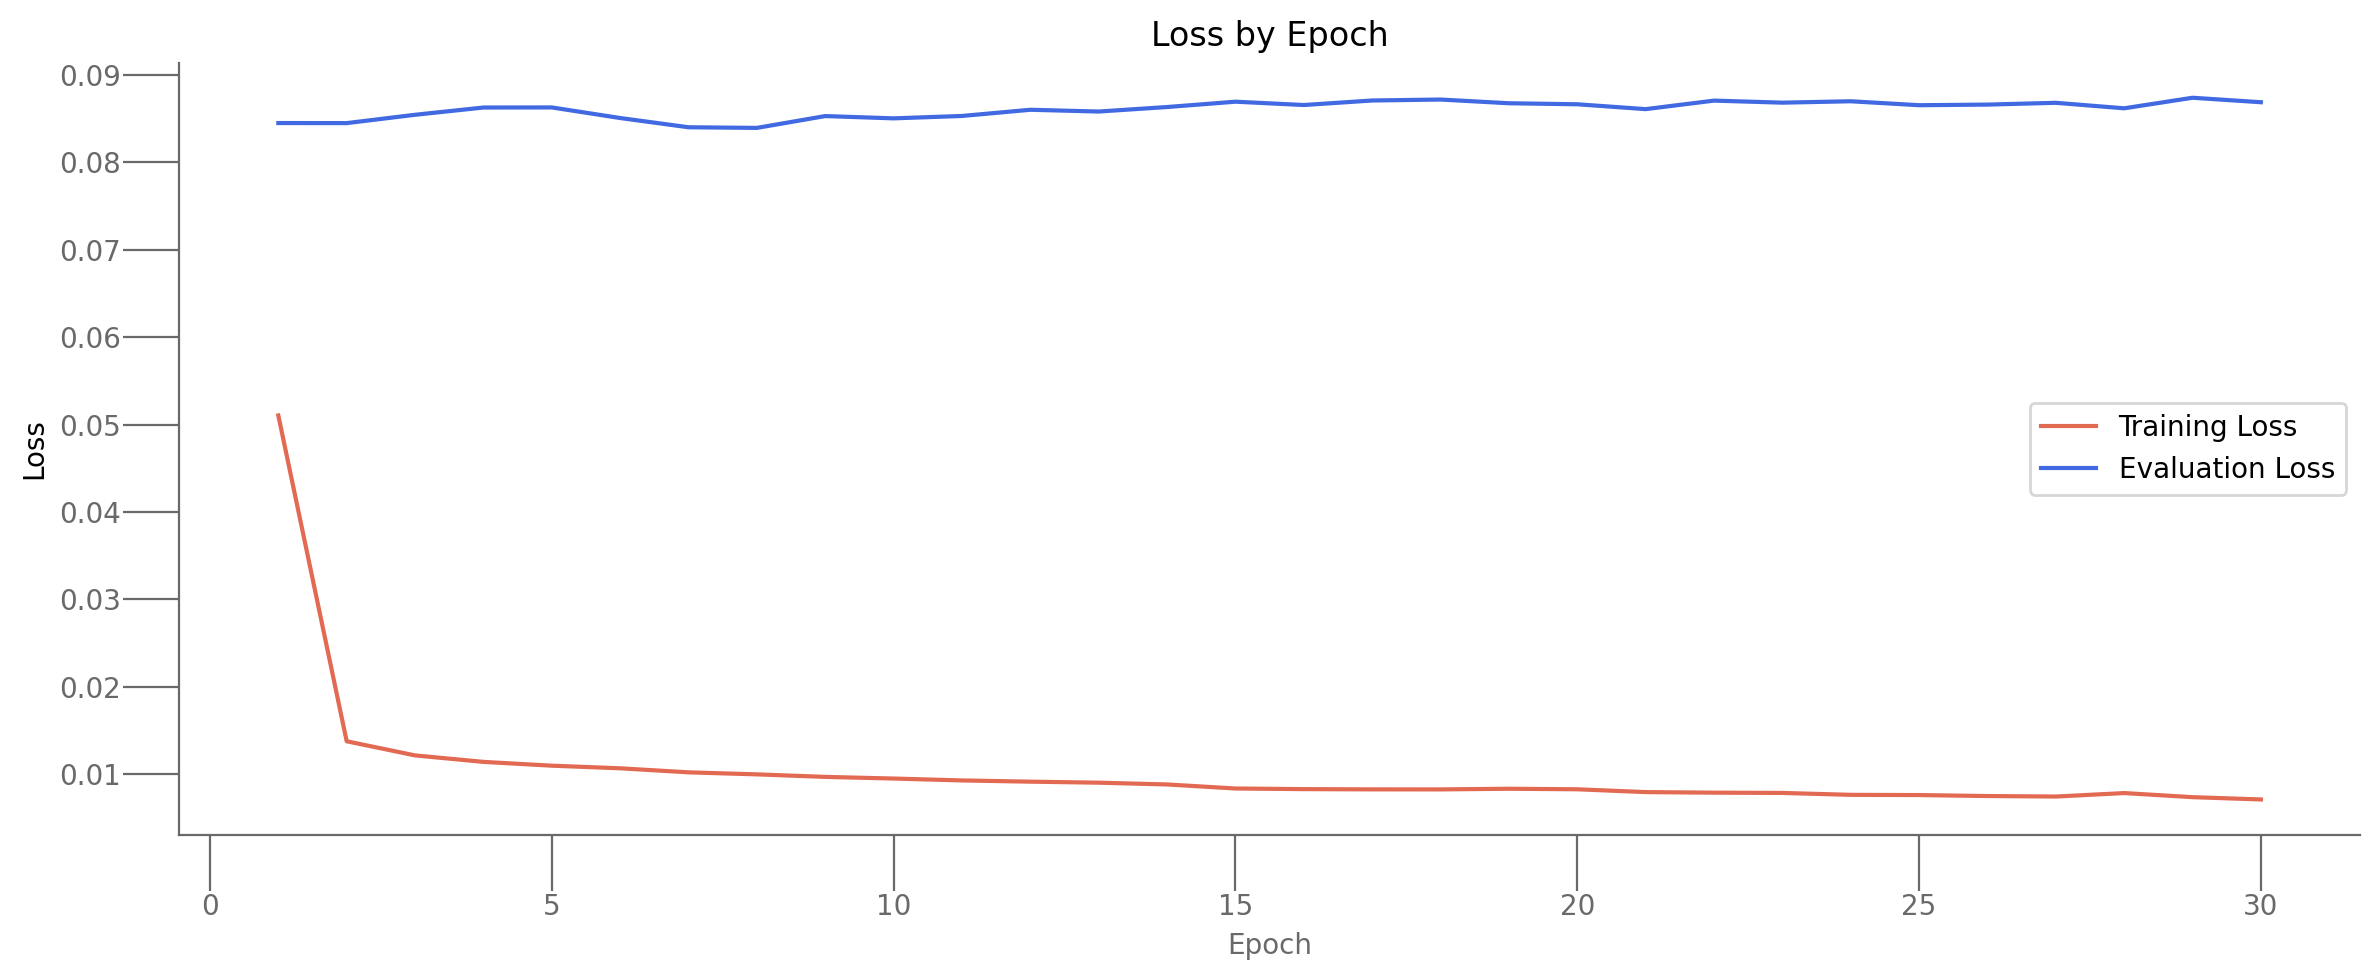

In [ ]:
plot_training_and_eval_losses(np.array(losses_bf), np.array(eval_losses_bf), 30, format_plot)

In [ ]:
r2score_tst_bf, losses_tst_bf, loss_nodes_bf, predictions_bf, real_bf = train_lstm.test(model_bf, dataloader_bf)


==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


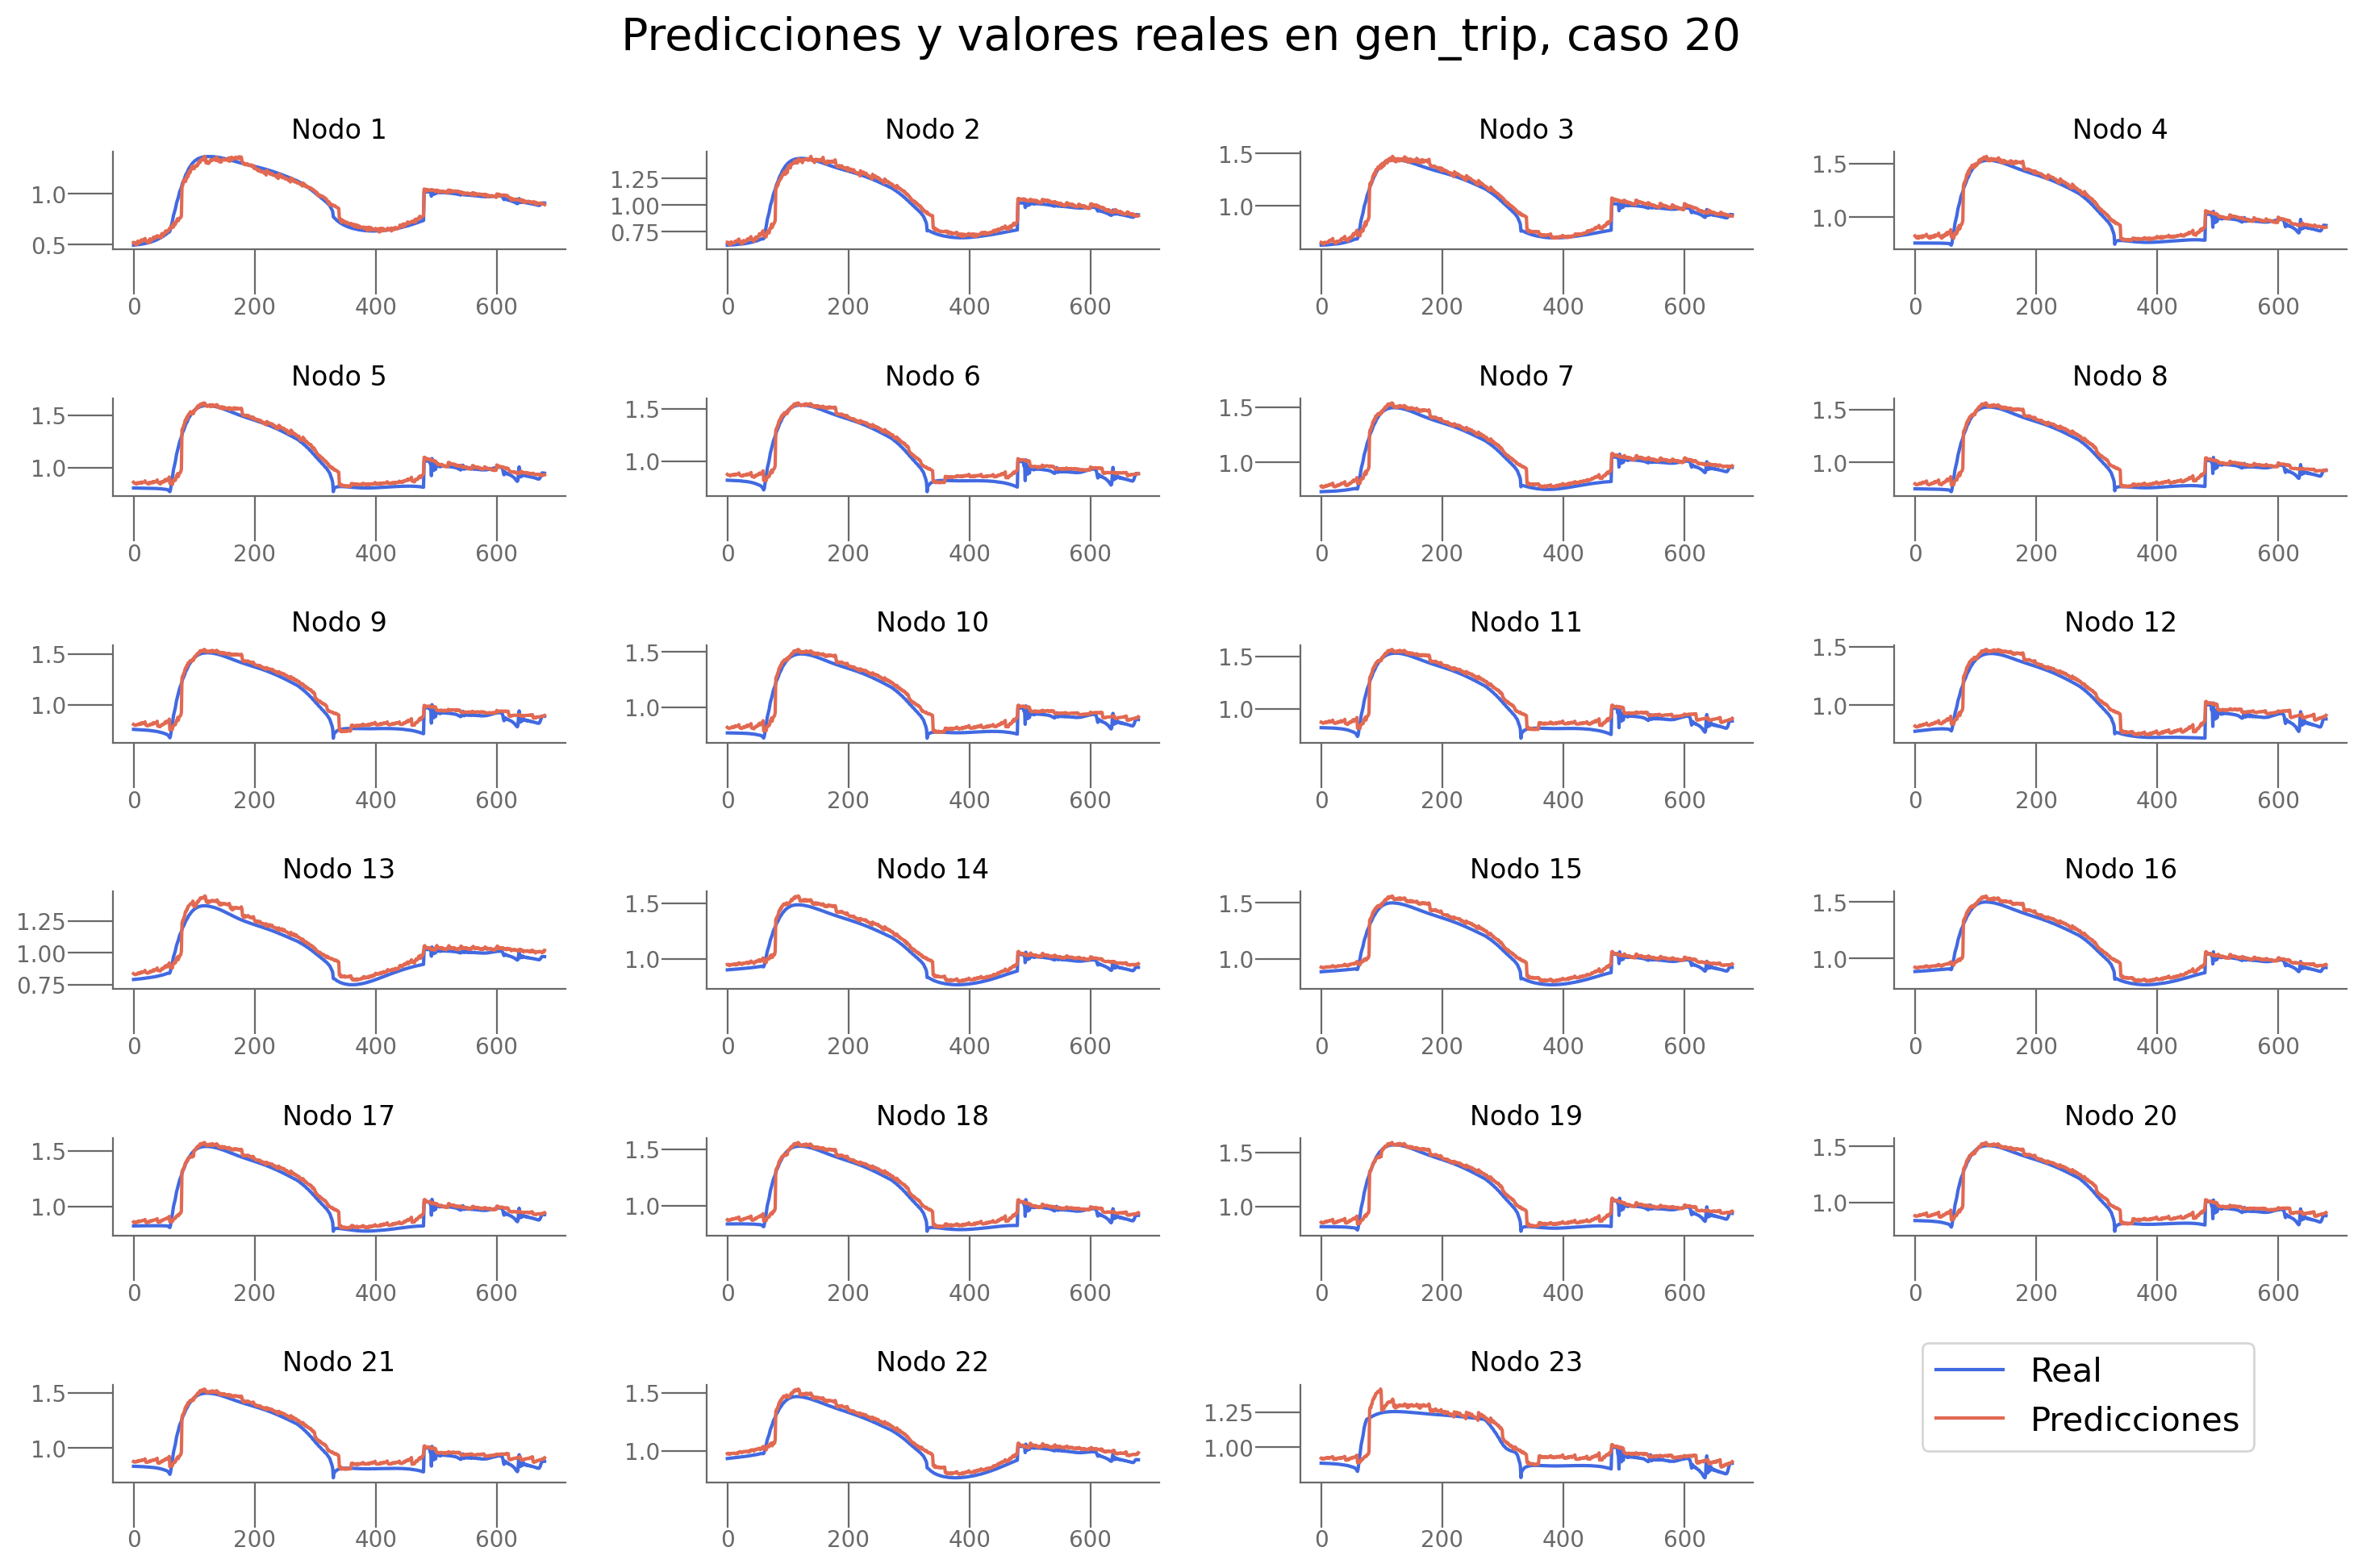

In [ ]:
plot_predictions(predictions_bf, real_bf, 20, 0, n_div_bf, problem)

In [ ]:
resultados_bf = {
    "loss_test": np.mean(losses_tst_bf),
    "r2_test": np.mean(r2score_tst_bf),
    "loss_nodes" : np.mean(loss_nodes_bf, axis=0),
    "r2_eval_final": r2scores_eval_bf[-1],
    "loss_eval_final": eval_losses_bf[-1],
    "loss_final": losses_bf[-1]
}


guardar_resultados(model_bf, "LSTM", problem, resultados_mejor_modelo=resultados_bf, results_path = "./results",path_save_experiment=None, params=None)



==================== GUARDANDO RESULTADOS ===================

  Modelo Params Fichero_resultados_experimento  Loss_tst   R2_tst  \
0   LSTM   None                           None  0.007442  0.35825   

                                          Loss_nodes  R2_eval  Loss_eval  \
0  [0.0029240102, 0.0031518377, 0.00446385, 0.007... -8.13717   0.086898   

   Loss_final  
0    0.007102  

==================== RESULTADOS GUARDADOS ===================



### Branch Fault

In [ ]:
problem = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [ ]:
n_div_brf = loader.div

#### Sencilla 

In [ ]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

dataloader_brf = trainer.train_test_val_split(dataset_brf, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])

model_brf, losses_brf, eval_losses_brf, r2scores_eval_brf = train_lstm.train_lstm_model(dataset_brf, params_model, dataloader_brf, num_epochs=30, lr=0.001, problem=problem, save_model = False, path_save = "./results" )



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN ===================

Epoch 1/30 | Train Loss: 0.0510 | Eval Loss: 0.0845 | Eval R2: -8.2851 | 
Epoch 2/30 | Train Loss: 0.0138 | Eval Loss: 0.0845 | Eval R2: -8.1360 | 
Epoch 3/30 | Train Loss: 0.0121 | Eval Loss: 0.0855 | Eval R2: -8.1906 | 
Epoch 4/30 | Train Loss: 0.0114 | Eval Loss: 0.0863 | Eval R2: -8.2660 | 
Epoch 5/30 | Train Loss: 0.0110 | Eval Loss: 0.0863 | Eval R2: -8.2862 | 
Epoch 6/30 | Train Loss: 0.0107 | Eval Loss: 0.0851 | Eval R2: -8.1323 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0840 | Eval R2: -8.0339 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0840 | Eval R2: -7.9828 | 
Epoch 9/30 | Train Loss: 0.0097 | Eval

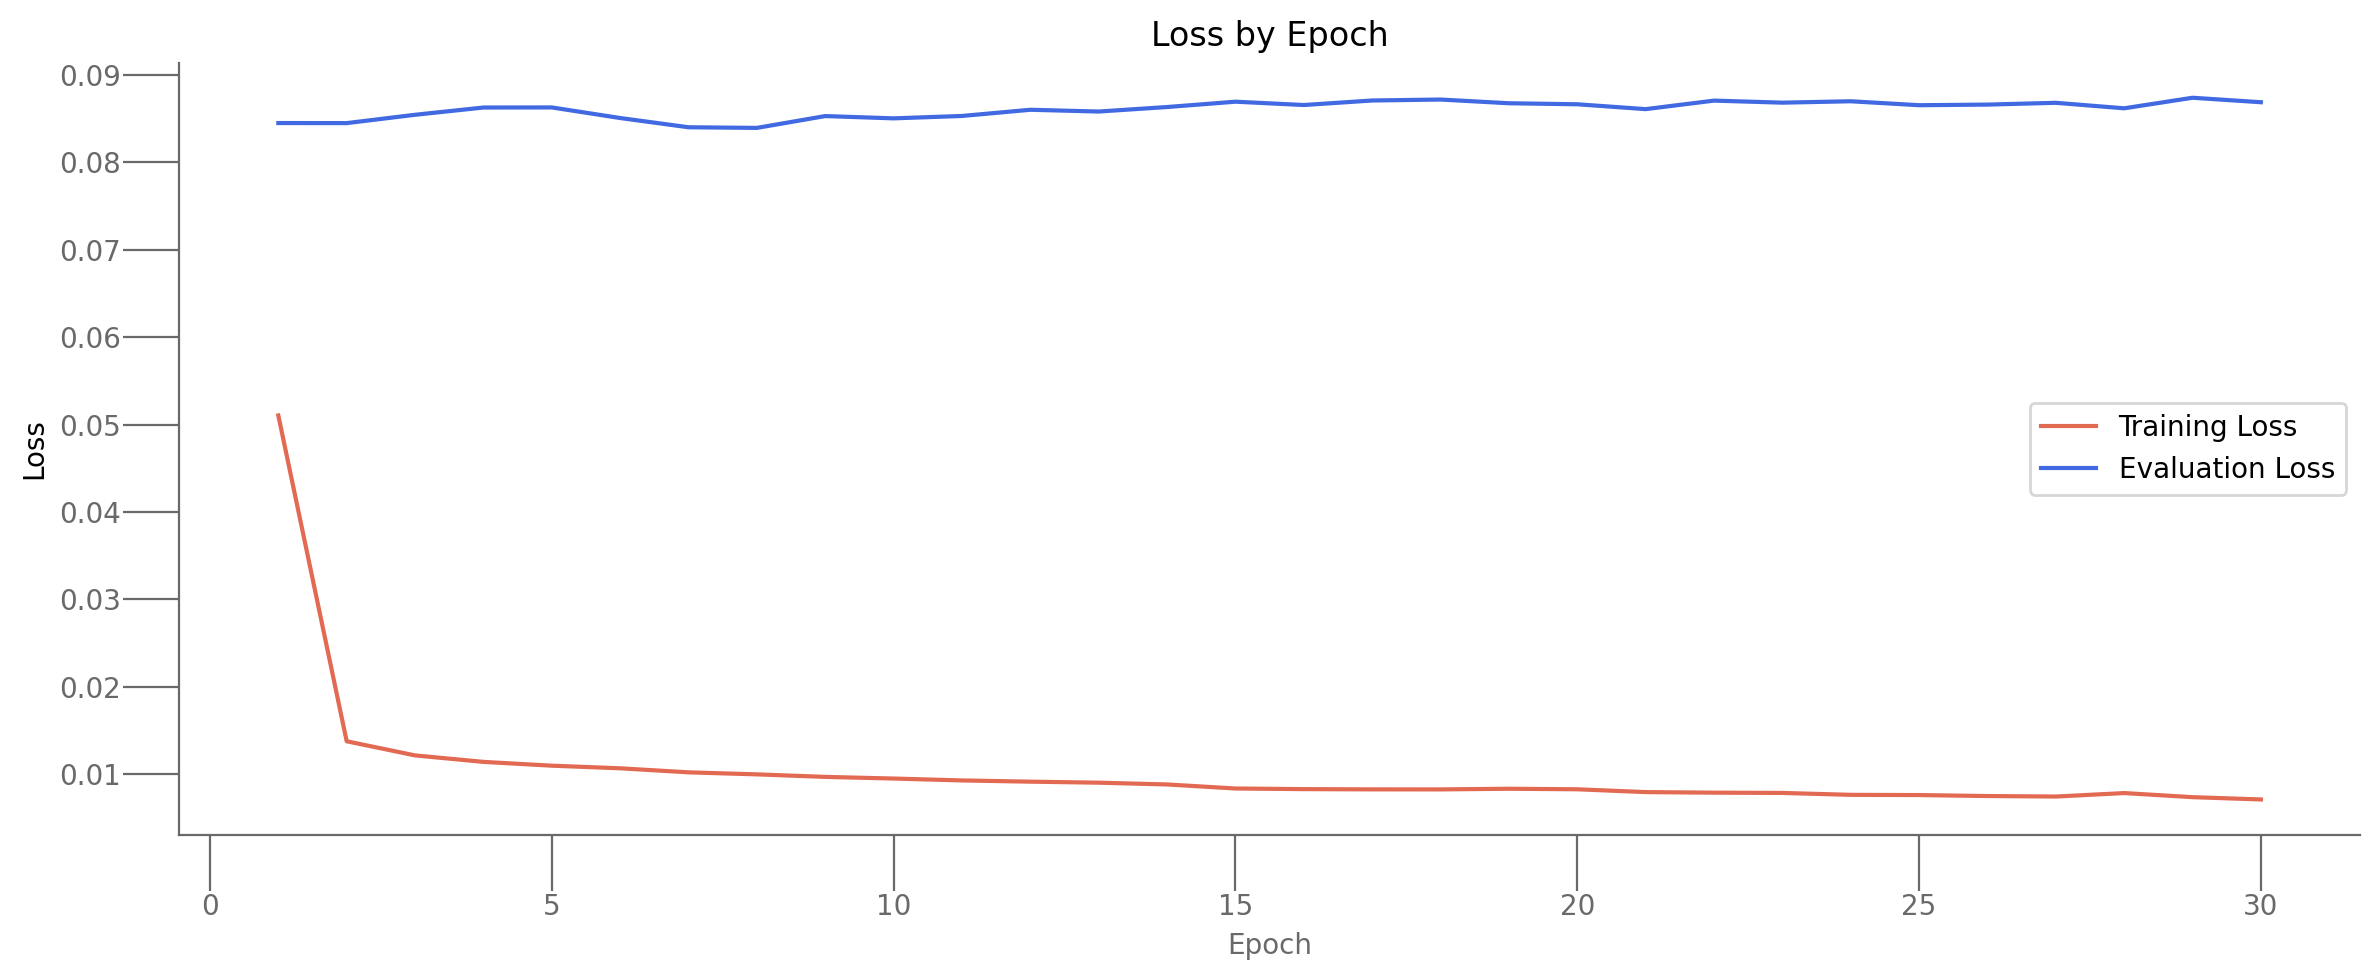

In [ ]:
plot_training_and_eval_losses(np.array(losses_brf), np.array(eval_losses_brf), 30, format_plot)

In [ ]:
r2score_tst_brf, losses_tst_brf, loss_nodes_brf, predictions_brf, real_brf = train_lstm.test(model_brf, dataloader_brf)


==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


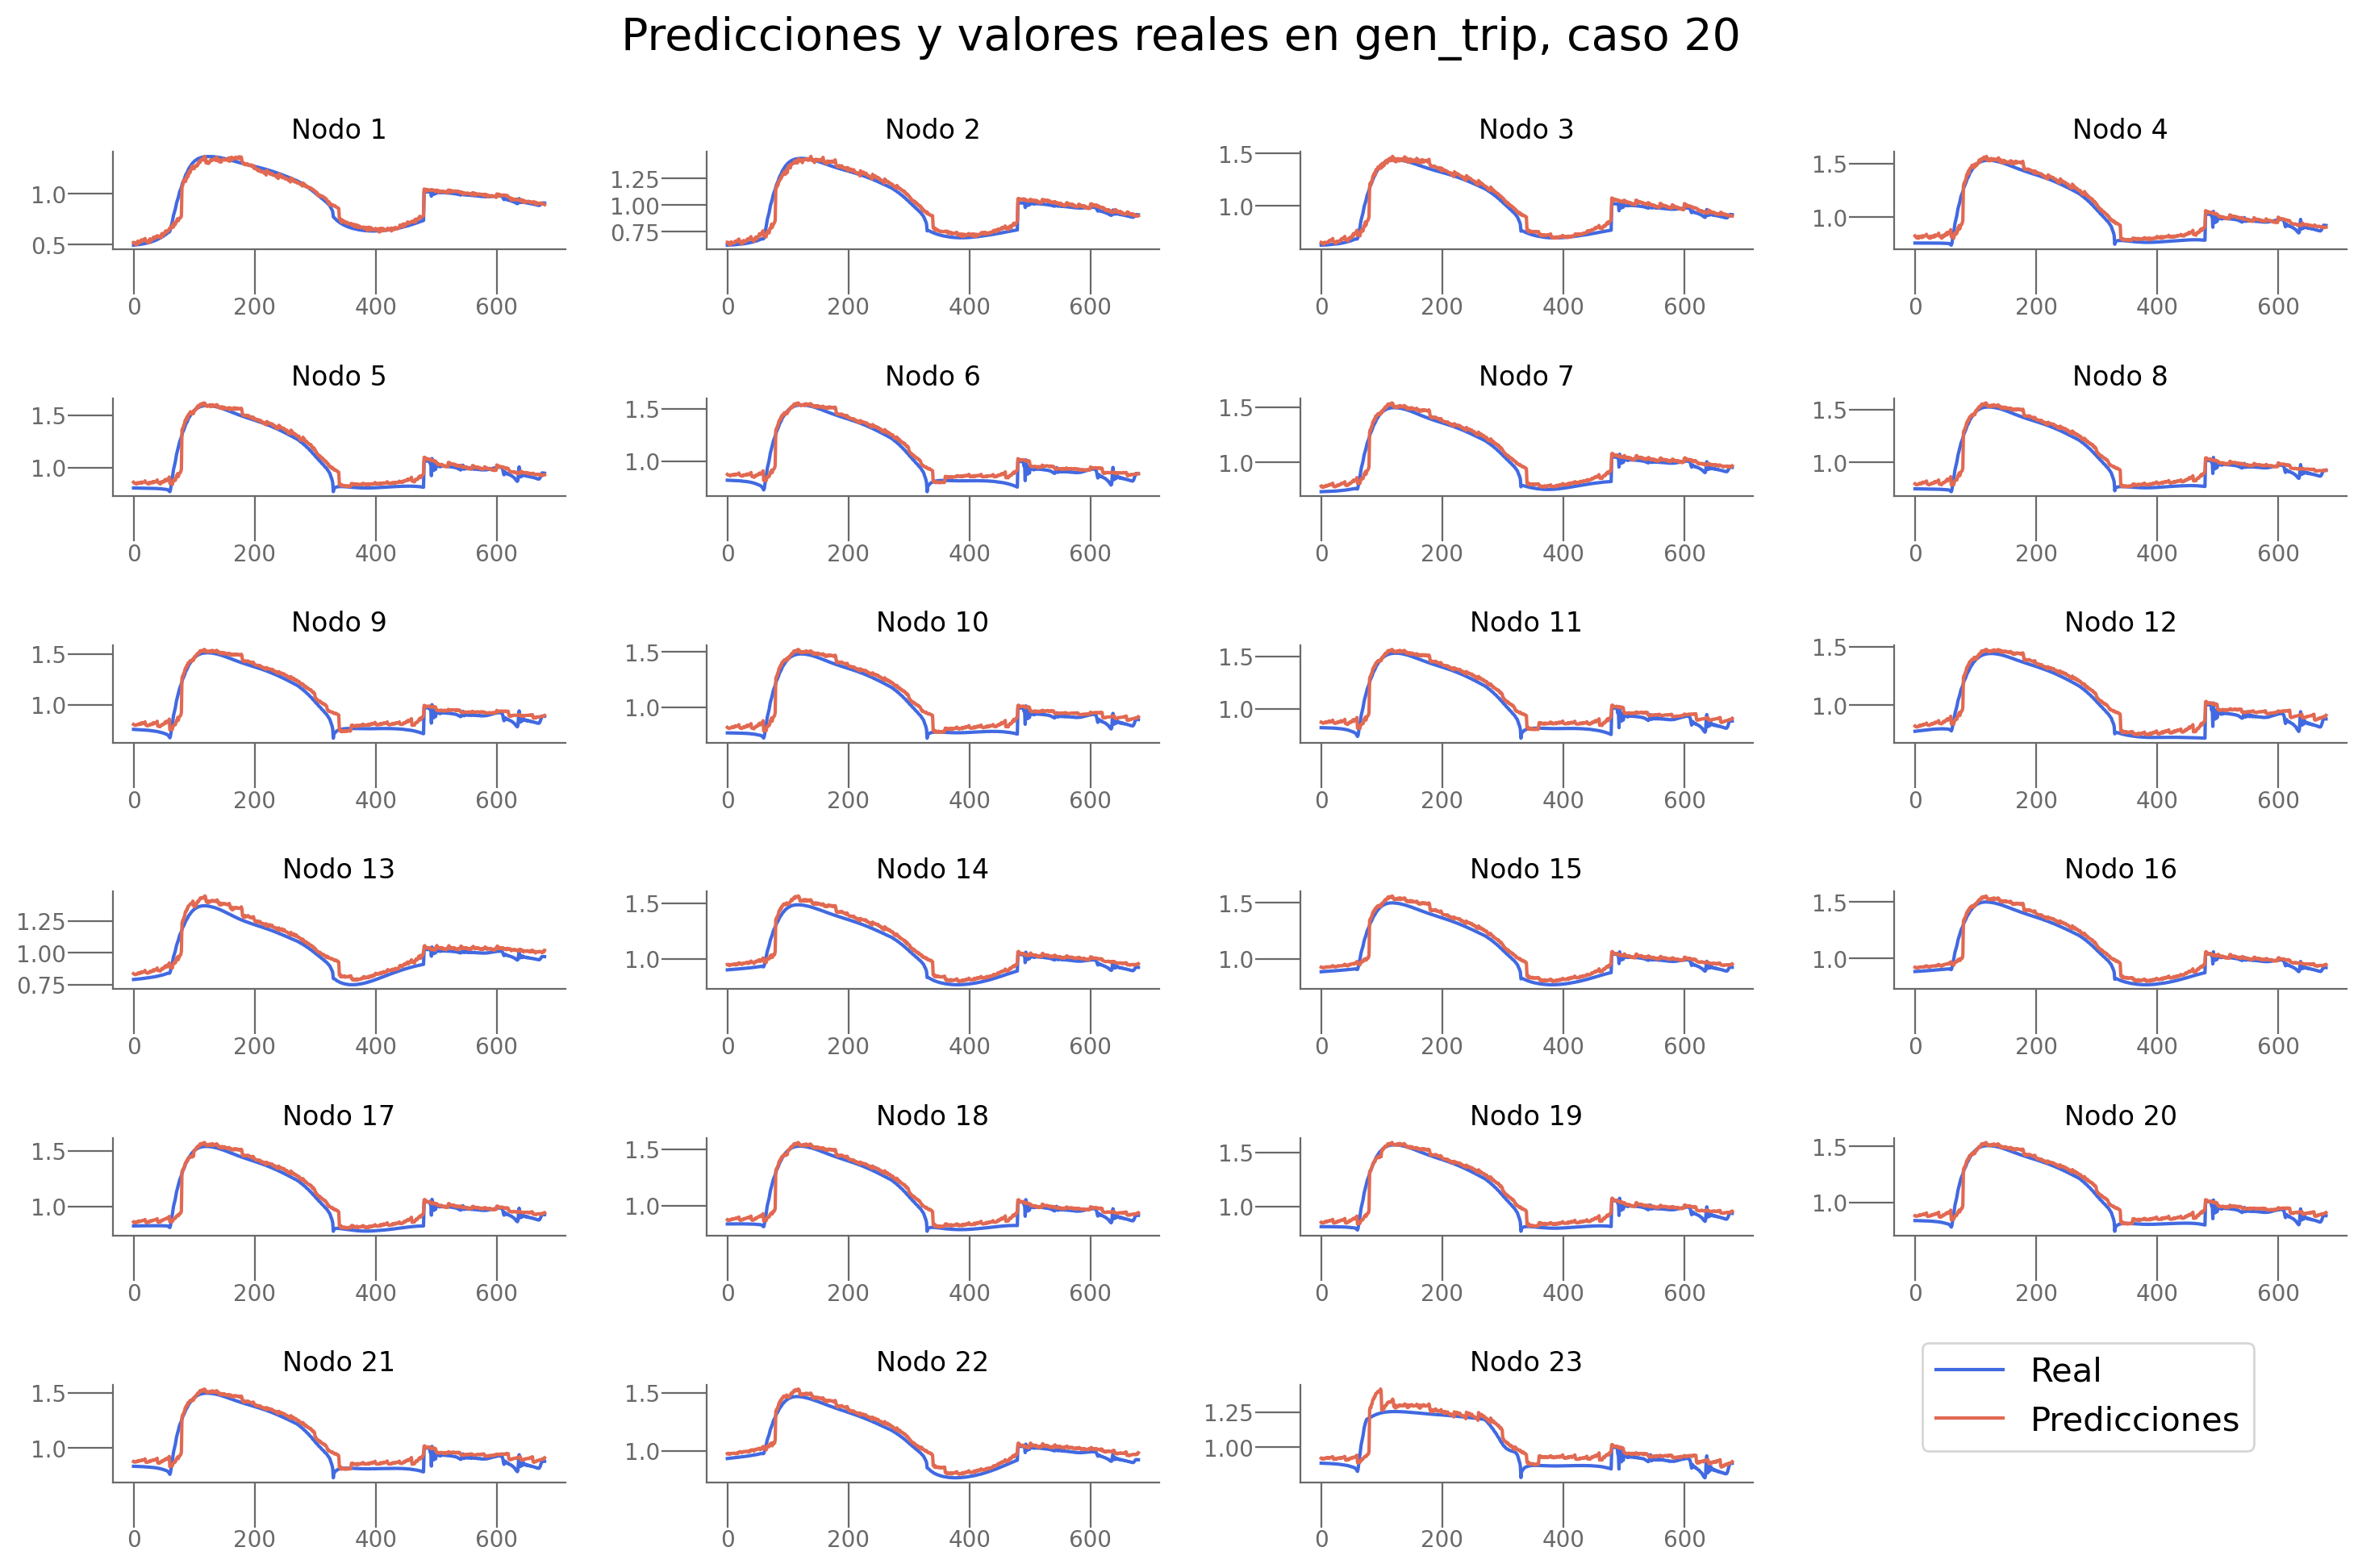

In [ ]:
plot_predictions(predictions_brf, real_brf, 20, 0, n_div_brf, problem)

In [ ]:
resultados_brf = {
    "loss_test": np.mean(losses_tst_brf),
    "r2_test": np.mean(r2score_tst_brf),
    "loss_nodes" : np.mean(loss_nodes_brf, axis=0),
    "r2_eval_final": r2scores_eval_brf[-1],
    "loss_eval_final": eval_losses_brf[-1],
    "loss_final": losses_brf[-1]
}


guardar_resultados(model_brf, "LSTM", problem, resultados_mejor_modelo=resultados_brf, results_path = "./results",path_save_experiment=None, params=None)



==================== GUARDANDO RESULTADOS ===================

  Modelo Params Fichero_resultados_experimento  Loss_tst   R2_tst  \
0   LSTM   None                           None  0.007442  0.35825   

                                          Loss_nodes  R2_eval  Loss_eval  \
0  [0.0029240102, 0.0031518377, 0.00446385, 0.007... -8.13717   0.086898   

   Loss_final  
0    0.007102  

==================== RESULTADOS GUARDADOS ===================



### Branch trip

In [ ]:
problem = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [ ]:
n_div_brt = loader.div

#### Sencilla 

In [ ]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

params_model = {
    "hidden_size": 50,
    "n_layers": 2
}

dataloader_brt= trainer.train_test_val_split(dataset_brt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])

model_brt, losses_brt, eval_losses_brt, r2scores_eval_brt = train_lstm.train_lstm_model(dataset_brt, params_model, dataloader_brt, num_epochs=30, lr=0.001, problem=problem, save_model = False, path_save = "./results" )



==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN ===================

Epoch 1/30 | Train Loss: 0.0510 | Eval Loss: 0.0845 | Eval R2: -8.2851 | 
Epoch 2/30 | Train Loss: 0.0138 | Eval Loss: 0.0845 | Eval R2: -8.1360 | 
Epoch 3/30 | Train Loss: 0.0121 | Eval Loss: 0.0855 | Eval R2: -8.1906 | 
Epoch 4/30 | Train Loss: 0.0114 | Eval Loss: 0.0863 | Eval R2: -8.2660 | 
Epoch 5/30 | Train Loss: 0.0110 | Eval Loss: 0.0863 | Eval R2: -8.2862 | 
Epoch 6/30 | Train Loss: 0.0107 | Eval Loss: 0.0851 | Eval R2: -8.1323 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0840 | Eval R2: -8.0339 | 
Epoch 8/30 | Train Loss: 0.0100 | Eval Loss: 0.0840 | Eval R2: -7.9828 | 
Epoch 9/30 | Train Loss: 0.0097 | Eval

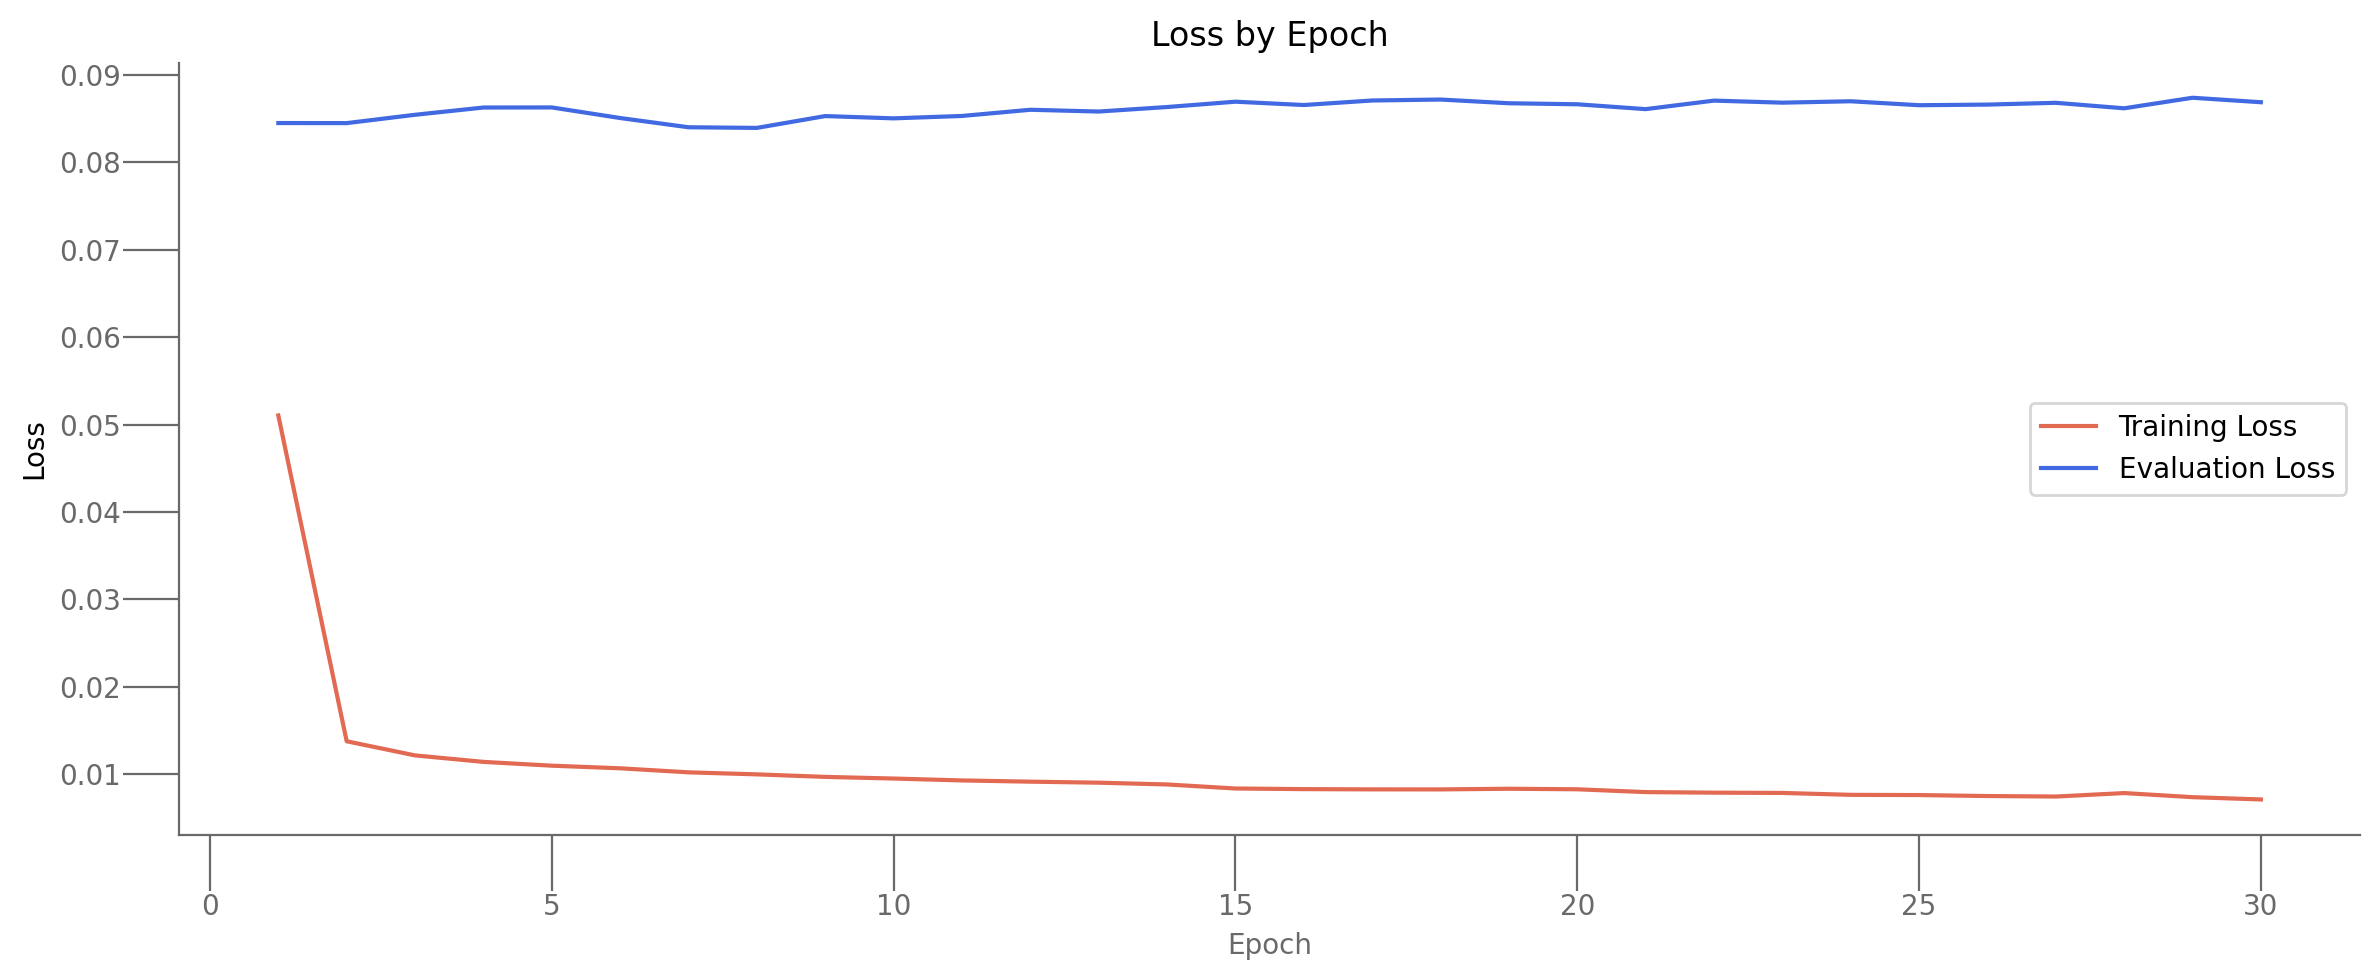

In [ ]:
plot_training_and_eval_losses(np.array(losses_brt), np.array(eval_losses_brt), 30, format_plot)

In [ ]:
r2score_tst_brt, losses_tst_brt, loss_nodes_brt, predictions_brt, real_brt = train_lstm.test(model_brt, dataloader_brt)


==================== TEST INFO ===================

Test_loss:0.0074, Test_r2:0.3582


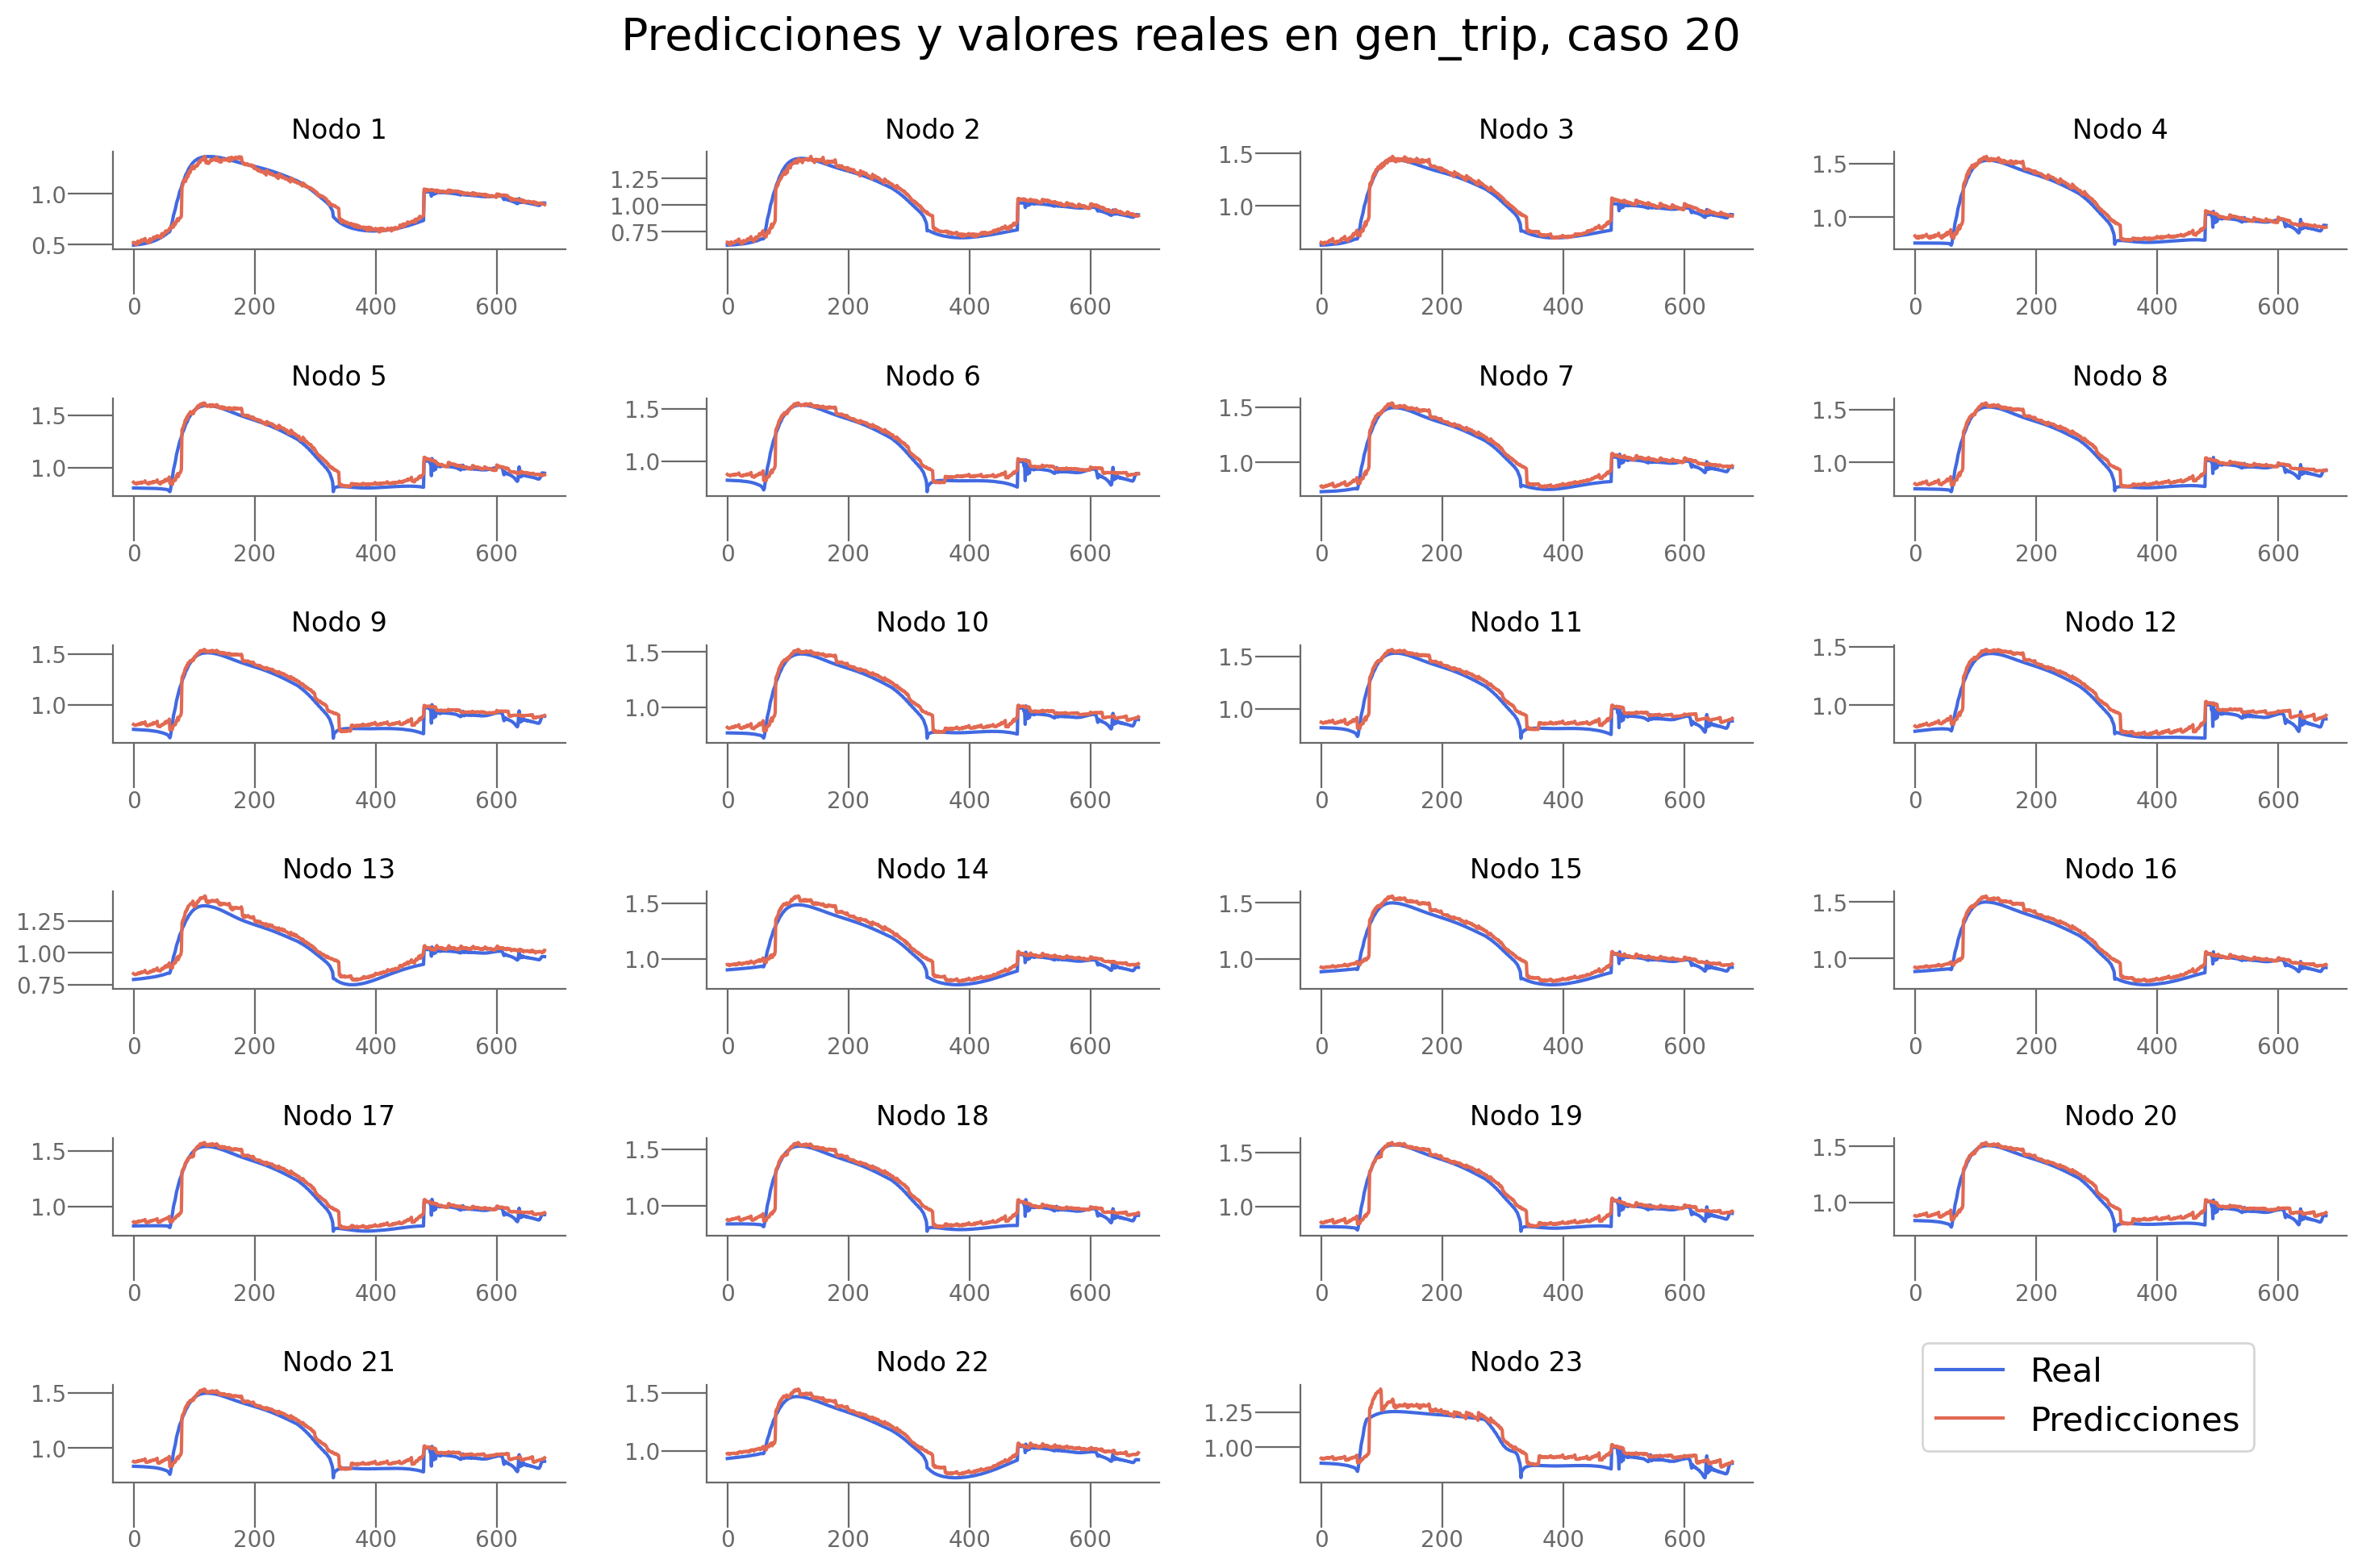

In [ ]:
plot_predictions(predictions_brt, real_brt, 20, 0, n_div_brt, problem)

In [ ]:
resultados_brt = {
    "loss_test": np.mean(losses_tst_brt),
    "r2_test": np.mean(r2score_tst_brt),
    "loss_nodes" : np.mean(loss_nodes_brt, axis=0),
    "r2_eval_final": r2scores_eval_brt[-1],
    "loss_eval_final": eval_losses_brt[-1],
    "loss_final": losses_brt[-1]
}


guardar_resultados(model_brt, "LSTM", problem, resultados_mejor_modelo=resultados_brt, results_path = "./results",path_save_experiment=None, params=None)



==================== GUARDANDO RESULTADOS ===================

  Modelo Params Fichero_resultados_experimento  Loss_tst   R2_tst  \
0   LSTM   None                           None  0.007442  0.35825   

                                          Loss_nodes  R2_eval  Loss_eval  \
0  [0.0029240102, 0.0031518377, 0.00446385, 0.007... -8.13717   0.086898   

   Loss_final  
0    0.007102  

==================== RESULTADOS GUARDADOS ===================

